### Data Processing (HR_proper.csv)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from geopy.geocoders import Nominatim
from geopy.distance import geodesic, distance

#### Load the data
Data [source](https://sites.google.com/eng.ucsd.edu/fitrec-project/home)

In [2]:
df_hr = pd.read_csv('Data/HR_proper.csv')

In [3]:
df_hr.head(1)

,longitude,altitude,latitude,sport,id,heart_rate,gender,timestamp,userId,speed
0,"[24.64977040886879, 24.65014273300767, 24.6509...","[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....","[60.173348765820265, 60.173239801079035, 60.17...",bike,396826535,"[100, 111, 120, 119, 120, 116, 125, 128, 131, ...",male,"[1408898746, 1408898754, 1408898765, 140889877...",10921915,"[6.8652, 16.4736, 19.1988, 20.4804, 31.3956, 3..."


#### Transform the data
- The time series features (`longitude`, `latitude`, `altitude`, `heart_rate`, `speed` and  `timestamp`) are all of string objects in the dataframe. Neet to transform the string objects to their numerical counterparts.

In [4]:
"""string data typ for the numerical features in the as-loaded dataframe"""
def str2num(x):
    values = np.array([])
    if type(x) == str:  #this is needed to work with missing values
        x = x.split()
        for item in x:
            item = item.strip('[,]')
            values = np.append(values, float(item))
    return values

In [5]:
# convert every numerical features to numpy array for consistency
features = ['longitude', 'latitude', 'altitude', 'timestamp', 'heart_rate']

In [6]:
df_hr[features] = df_hr[features].applymap(str2num)

#### Feature Engineering
1. Derived features:
    - `distance_mean_m`/`speed_mean`: mean distance/speed traveled between consecutive pairs of time steps. The unit is in *meter* and *meter/second*, respectively.
    - `distance_std_m`/`speed_std`: standard deviation of the entire step distance/speed series of a workout session. The unit is in *meter*.
    - `distance_total_m`: total distance traveled of a workout session. The unit is in *meter*.
    - 'altitude_mean': mead altitude value of a workout session. The unit is in *meter*.
    - 'altitude_std': standard deviation value of the altitude from a workout session.
    - `ascend_m`: total ascend value of a workout session. The unit is in *meter*.
    - `descend_m`: total descend value of a workout session. The unit is in *meter*.
    - `duration_s`: time span of a workout session, The unit is in *second*.
    - `start_end`: The start and end timestamps of a workout session. The unit is in *second*.
    - `heart_rate_mean`: mean heart rate of a workout session.
    - `heart_rate_std`: standard deviation value of the heart rate during a workout session.

2. Features dropped:
    - In the light version (HR_proper_light.pkl), all the time series features (`longitude`, `latitude`, `altitude`, `timestamp`, `heart_rate`) are dropped.
    - All the features are kept in the full version (HR_proper_full.pkl).

In [31]:
def coord2features(df):
    # new features
    distance_mean = []
    distance_std = []
    distance_total = []
    speed_mean = []
    speed_std = []
    start_end = []
    duration = []
    altitude_mean = []
    altitude_std = []
    ascend = []
    descend = []
    heart_rate_mean = []
    heart_rate_std = []
    
    # main loop to go through the whole dataframe
    for idx in df.index:
        
        # distance_step and speed calculation
        lat = df['latitude'].loc[idx]
        lon = df['longitude'].loc[idx]
        alt = df['altitude'].loc[idx]
        if len(lat) != len(lon):
            print('latitude and longitude have different lengths')
            break
        
        distance_session = np.array([]) 
        speed_session = np.array([])
        ascend_session = 0
        descend_session = 0
        for step in range(len(lat)-1):
            loc_i = (lat[step], lon[step])
            loc_f = (lat[step+1], lon[step+1])
            length_step = distance(loc_i, loc_f).meters
            distance_session = np.append(distance_session, length_step)
            
            time_step = df.timestamp.loc[idx][step+1] - \
                        df.timestamp.loc[idx][step]
            
            alt_diff = alt[step+1] - alt[step]
            if alt_diff >= 0:
                ascend_session += alt_diff
            elif alt_diff < 0:
                descend_session += abs(alt_diff) 
            
            if time_step == 0.:
                speed_session = np.append(speed_session, np.nan)
            else:
                speed_session = np.append(speed_session, length_step/time_step)
        
        #distance features
        distance_mean.append(np.nanmean(distance_session))
        distance_std.append(np.nanstd(distance_session))
        distance_total.append(np.nansum(distance_session))
        
        #speed features
        speed_mean.append(np.nanmean(speed_session))
        speed_std.append(np.nanstd(speed_session))   
        
        #duration feature
        start_end.append(np.array([df.timestamp.loc[idx][0],
                                   df.timestamp.loc[idx][-1]]))
        duration.append(df.timestamp.loc[idx][-1] - df.timestamp.loc[idx][0])
        
        ascend.append(ascend_session)
        descend.append(descend_session)
        heart_rate_mean.append(df['heart_rate'].loc[idx].mean())
        heart_rate_std.append(df['heart_rate'].loc[idx].std())
        altitude_mean.append(df['altitude'].loc[idx].mean())
        altitude_std.append(df['altitude'].loc[idx].std())
            
    df['distance_mean_m'] = distance_mean
    df['distance_std_m'] = distance_std
    df['distance_total_m'] = distance_total
    df['speed_mean'] = speed_mean
    df['speed_std'] = speed_std
    df['altitude_mean'] = altitude_mean
    df['altitude_std'] = altitude_std
    df['ascend_m'] = ascend
    df['descend_m'] = descend
    df['duration_s'] = duration
    df['start_end'] = start_end
    df['heart_rate_mean'] = heart_rate_mean
    df['heart_rate_std'] = heart_rate_std
    #df = df.drop(['latitude', 'longitude', 'speed', ], axis=1)
    df = df.drop(['speed'], axis=1)
    return df

In [57]:
df_hr.columns

Index(['longitude', 'altitude', 'latitude', 'sport', 'id', 'heart_rate',
       'gender', 'timestamp', 'userId', 'distance_mean_m', 'distance_std_m',
       'distance_total_m', 'speed_mean', 'speed_std', 'altitude_mean',
       'altitude_std', 'ascend_m', 'descend_m', 'duration_s', 'start_end',
       'heart_rate_mean', 'heart_rate_std'],
      dtype='object')

#### Save the data as pickle files

In [65]:
order_full = ['id', 'userId', 'gender', 'sport', 'heart_rate_mean',
              'heart_rate_std', 'duration_s', 'start_end', 'altitude_mean',
              'altitude_std', 'ascend_m', 'descend_m', 'distance_mean_m',
              'distance_std_m', 'distance_total_m', 'speed_mean', 'speed_std',
              'timestamp', 'heart_rate', 'altitude', 'longitude', 'latitude']

In [59]:
len(df_hr.columns)

22

In [71]:
len(order_full)

22

In [66]:
df_hr[order_full].head(1)

,id,userId,gender,sport,heart_rate_mean,heart_rate_std,duration_s,start_end,altitude_mean,altitude_std,...,distance_mean_m,distance_std_m,distance_total_m,speed_mean,speed_std,timestamp,heart_rate,altitude,longitude,latitude
0,396826535,10921915,male,bike,152.65,10.229736,7589.0,"[1408898746.0, 1408906335.0]",43.0712,13.4759,...,106.309446,57.798961,53048.413644,7.117435,2.182678,"[1408898746.0, 1408898754.0, 1408898765.0, 140...","[100.0, 111.0, 120.0, 119.0, 120.0, 116.0, 125...","[41.6, 40.6, 40.6, 38.4, 37.0, 34.0, 34.0, 34....","[24.64977040886879, 24.65014273300767, 24.6509...","[60.173348765820265, 60.173239801079035, 60.17..."


In [67]:
df_hr[order_full].to_pickle('Data/HR_proper_full.pkl')

In [68]:
order_light = ['id', 'userId', 'gender', 'sport', 'heart_rate_mean',
              'heart_rate_std', 'duration_s', 'start_end', 'altitude_mean',
              'altitude_std', 'ascend_m', 'descend_m', 'distance_mean_m',
              'distance_std_m', 'distance_total_m', 'speed_mean', 'speed_std']

In [72]:
len(order_light)

17

In [69]:
df_hr[order_light].head(1)

,id,userId,gender,sport,heart_rate_mean,heart_rate_std,duration_s,start_end,altitude_mean,altitude_std,ascend_m,descend_m,distance_mean_m,distance_std_m,distance_total_m,speed_mean,speed_std
0,396826535,10921915,male,bike,152.65,10.229736,7589.0,"[1408898746.0, 1408906335.0]",43.0712,13.4759,407.6,413.0,106.309446,57.798961,53048.413644,7.117435,2.182678


In [70]:
df_hr[order_light].to_pickle('Data/HR_proper_light.pkl')

### random notes

/var/folders/b2/vv24sgvs7hbbkc51h5cd99xw0000gn/T/ipykernel_4552/3598327835.py:11: RuntimeWarning: divide by zero encountered in true_divide
  ax.plot(x, y2/y2.max(), label='altitude')
/var/folders/b2/vv24sgvs7hbbkc51h5cd99xw0000gn/T/ipykernel_4552/3598327835.py:11: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(x, y2/y2.max(), label='altitude')


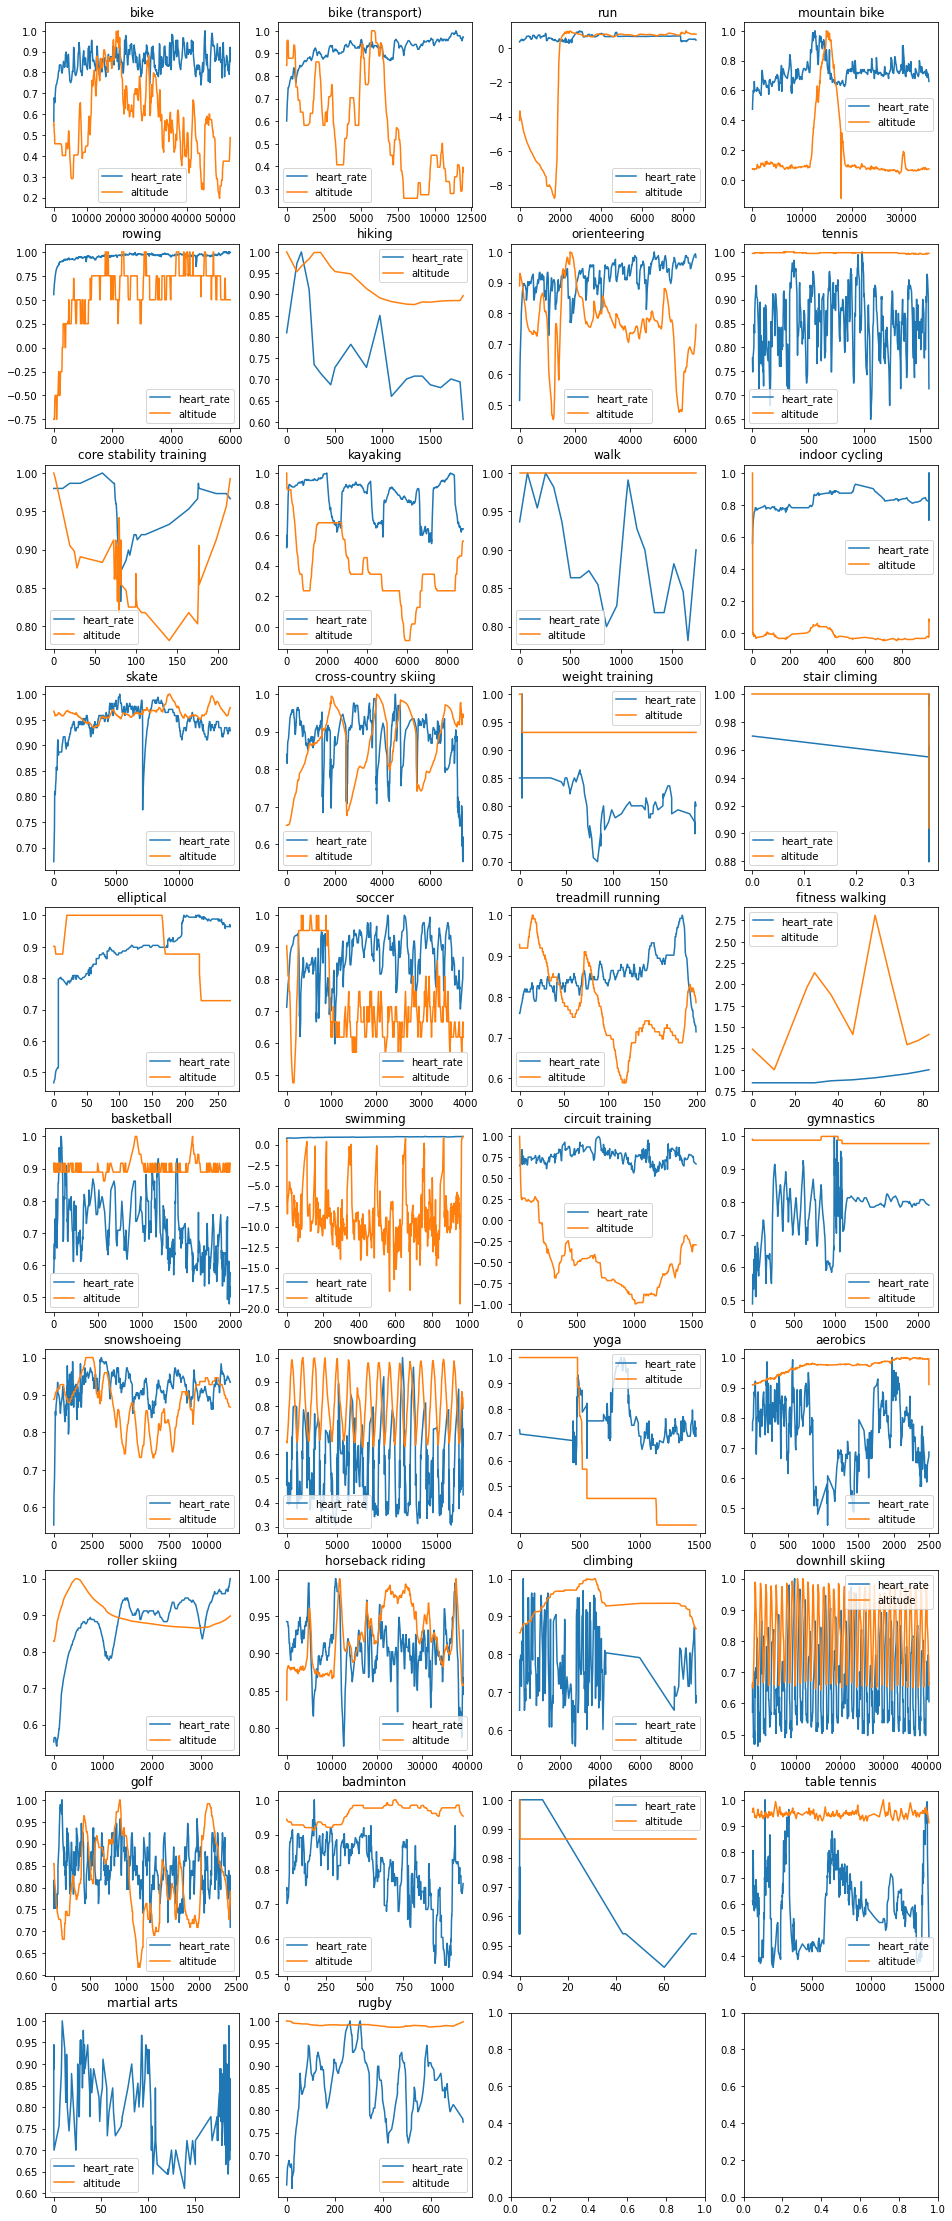

In [ ]:
side = 4
sports = df_sport.sport.unique()
fig, axs = plt.subplots(nrows=10, ncols=4, figsize=(side*4, side*10))
#axs = axs.ravel()

for ax, sport in zip(axs.ravel(), sports):
    x = df_sport[df_sport.sport == sport].distance_traveled.iloc[0]
    y1 = df_sport[df_sport.sport == sport].heart_rate.iloc[0]
    y2 = df_sport[df_sport.sport == sport].altitude.iloc[0]
    ax.plot(x, y1/y1.max(), label='heart_rate')
    ax.plot(x, y2/y2.max(), label='altitude')
    ax.set_title(sport)
    ax.legend()
    #axs.plot(df_sport[df_sport.distance_traveled)

#for i in range(len(df_sport)//5):
#    